# Label Shuffle Experiment for Progressive Learning
### Import necessary packages and modules

In [1]:
import sys
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from joblib import Parallel, delayed
from multiprocessing import Pool
import time
from itertools import product
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from math import log2, ceil 
import seaborn as sns
import matplotlib.pyplot as plt

### Import models from proglearn
Append the path for where your proglearn to sys

In [2]:
sys.path.append("../proglearn/")
from progressive_learner import ProgressiveLearner
from deciders import SimpleAverage
from transformers import TreeClassificationTransformer, NeuralClassificationTransformer 
from voters import TreeClassificationVoter, KNNClassificationVoter

### Load CIFAR100 data 

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])

### Functions
Functions for training the model

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    
    batch_per_task=5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                indx = np.roll(idx[class_no],(shift-1)*100)
                
                if batch==0 and class_no==0 and task==0:
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]
                    train_y = np.random.randint(low = 0, high = total_task, size = sample_per_class)
                    test_y = np.random.randint(low = 0, high = total_task, size = total_task)
                else:
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    if task == 0:
                        train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                        test_y = np.concatenate((test_y, y[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    else:
                        train_y = np.concatenate((train_y, np.random.randint(low = 0, high = total_task, size = sample_per_class)), axis=0)
                        test_y = np.concatenate((test_y, np.random.randint(low = 0, high = total_task, size = total_task)), axis = 0)
                
    return train_x, train_y, test_x, test_y

In [7]:
def run_parallel_exp(data_x, data_y, n_trees, model, num_points_per_task, slot=0, shift=1):
    train_x, train_y, test_x, test_y = cross_val_data(data_x, data_y, num_points_per_task, shift=shift)
    
    if model == "dnn":
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        with tf.device('/gpu:'+str(shift % 4)):
            LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
    else:
        LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)

In [8]:
def LF_experiment(train_x, train_y, test_x, test_y, ntrees, shift, slot, model, num_points_per_task, acorn=None):
       
    df = pd.DataFrame()
    shifts = []
    tasks = []
    base_tasks = []
    accuracies_across_tasks = []
    train_times_across_tasks = []
    inference_times_across_tasks = []
    
    if model == "dnn":
        default_transformer_class = NeuralClassificationTransformer
        
        network = keras.Sequential()
        network.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=np.shape(train_x)[1:]))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=254, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))

        network.add(layers.Flatten())
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(units=10, activation = 'softmax'))
        
        default_transformer_kwargs = {"network" : network, 
                                      "euclidean_layer_idx" : -2,
                                      "num_classes" : 10,
                                      "optimizer" : keras.optimizers.Adam(3e-4)
                                     }
        
        default_voter_class = KNNClassificationVoter
        default_voter_kwargs = {"k" : 16 * int(np.log2(num_points_per_task))}
        
        default_decider_class = SimpleAverage
    elif model == "uf":
        default_transformer_class = TreeClassificationTransformer
        default_transformer_kwargs = {"kwargs" : {"max_depth" : 30}}
        
        default_voter_class = TreeClassificationVoter
        default_voter_kwargs = {}
        
        default_decider_class = SimpleAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class)

    for task_ii in range(10):
        print("Starting Task {} For Fold {} For Slot {}".format(task_ii, shift, slot))
        if acorn is not None:
            np.random.seed(acorn)

        train_start_time = time.time()
        progressive_learner.add_task(
            X = train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task], 
            y = train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task],
            num_transformers = 1 if model == "dnn" else ntrees,
            transformer_voter_decider_split = [0.67, 0.33, 0],
            decider_kwargs = {"classes" : np.unique(train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task])},
            backward_task_ids=[0]
            )
        train_end_time = time.time()
        
        inference_start_time = time.time()
        llf_task=progressive_learner.predict(
            test_x[:1000], task_id=0
            )
        inference_end_time = time.time()
        acc = np.mean(
                    llf_task == test_y[:1000]
                    )
        accuracies_across_tasks.append(acc)
        shifts.append(shift)
        train_times_across_tasks.append(train_end_time - train_start_time)
        inference_times_across_tasks.append(inference_end_time - inference_start_time)
        
        print("Accuracy Across Tasks: {}".format(accuracies_across_tasks))
        print("Train Times Across Tasks: {}".format(train_times_across_tasks))
        print("Inference Times Across Tasks: {}".format(inference_times_across_tasks))
            
    df['data_fold'] = shifts
    df['task'] = range(1, 11)
    df['task_1_accuracy'] = accuracies_across_tasks
    df['train_times'] = train_times_across_tasks
    df['inference_times'] = inference_times_across_tasks

    file_to_save = '../tutorials/result/'+model+str(ntrees)+'_'+str(shift)+'_'+str(slot)+'.pickle'
    with open(file_to_save, 'wb') as f:
        pickle.dump(df, f)

### Define hyperparameters for the model and run model
For model, choose between dnn (deep neural network) and uf (uncertainty forest) 

In [9]:
model = "dnn"
num_points_per_task = 500

if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

slot_fold = range(int(5000 // num_points_per_task))

#%%
if model == "uf":
    shift_fold = range(1,7,1)
    n_trees=[10]
    iterable = product(n_trees,shift_fold,slot_fold)
    Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )
elif model == "dnn":
    
    for slot in slot_fold:
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
        
        stage_1_shifts = range(1, 5)
        with Pool(4) as p:
            p.map(perform_shift, stage_1_shifts) 
            
        stage_2_shifts = range(5, 7)
        with Pool(4) as p:
            p.map(perform_shift, stage_2_shifts) 

Starting Task 0 For Fold 1 For Slot 0
Starting Task 0 For Fold 2 For Slot 0
Starting Task 0 For Fold 3 For Slot 0
Starting Task 0 For Fold 4 For Slot 0
Accuracy Across Tasks: [0.151]
Train Times Across Tasks: [17.17846703529358]
Inference Times Across Tasks: [1.6271045207977295]
Starting Task 1 For Fold 1 For Slot 0
Accuracy Across Tasks: [0.136]
Train Times Across Tasks: [17.21433424949646]
Inference Times Across Tasks: [1.6080334186553955]
Starting Task 1 For Fold 3 For Slot 0
Accuracy Across Tasks: [0.13]
Train Times Across Tasks: [18.256473541259766]
Inference Times Across Tasks: [1.4618868827819824]
Starting Task 1 For Fold 4 For Slot 0
Accuracy Across Tasks: [0.162]
Train Times Across Tasks: [19.2700777053833]
Inference Times Across Tasks: [1.4216594696044922]
Starting Task 1 For Fold 2 For Slot 0
Accuracy Across Tasks: [0.136, 0.167]
Train Times Across Tasks: [17.21433424949646, 6.568111896514893]
Inference Times Across Tasks: [1.6080334186553955, 4.285094738006592]
Starting Tas

Inference Times Across Tasks: [1.4913749694824219, 3.8653783798217773, 6.218886613845825, 8.649701356887817]
Starting Task 4 For Fold 6 For Slot 0
Accuracy Across Tasks: [0.148, 0.22, 0.236, 0.225]
Train Times Across Tasks: [10.745668649673462, 10.29736590385437, 11.220229625701904, 11.179811239242554]
Inference Times Across Tasks: [1.461381196975708, 3.7715110778808594, 6.181826829910278, 8.484441995620728]
Starting Task 4 For Fold 5 For Slot 0
Accuracy Across Tasks: [0.148, 0.208, 0.214, 0.24, 0.259]
Train Times Across Tasks: [6.130504608154297, 11.756285667419434, 10.329142332077026, 12.910792350769043, 11.345680236816406]
Inference Times Across Tasks: [1.4913749694824219, 3.8653783798217773, 6.218886613845825, 8.649701356887817, 10.901002883911133]
Starting Task 5 For Fold 6 For Slot 0
Accuracy Across Tasks: [0.148, 0.22, 0.236, 0.225, 0.217]
Train Times Across Tasks: [10.745668649673462, 10.29736590385437, 11.220229625701904, 11.179811239242554, 13.214264869689941]
Inference Times

Inference Times Across Tasks: [1.765470266342163, 4.208766937255859, 6.803616523742676, 9.342800378799438, 11.571423768997192, 14.388535737991333, 16.440363883972168, 19.13452649116516]
Starting Task 8 For Fold 2 For Slot 1
Accuracy Across Tasks: [0.147, 0.225, 0.232, 0.25, 0.256, 0.278, 0.283, 0.29, 0.286]
Train Times Across Tasks: [8.160409212112427, 6.815068960189819, 10.601412534713745, 19.642386198043823, 9.0935218334198, 12.392438173294067, 15.353259563446045, 9.380896806716919, 11.402653694152832]
Inference Times Across Tasks: [1.6669564247131348, 4.289670705795288, 6.733236074447632, 9.145930051803589, 11.730194330215454, 14.169617176055908, 16.986316442489624, 19.09603977203369, 21.791553497314453]
Starting Task 9 For Fold 4 For Slot 1
Accuracy Across Tasks: [0.165, 0.22, 0.243, 0.241, 0.291, 0.284, 0.311, 0.314, 0.309]
Train Times Across Tasks: [8.686599969863892, 16.224440097808838, 13.54523777961731, 9.256165742874146, 13.95284914970398, 7.912160158157349, 13.91141939163208

Inference Times Across Tasks: [1.6246922016143799, 4.1995849609375, 6.744783639907837, 9.485081672668457, 10.884228467941284]
Starting Task 5 For Fold 2 For Slot 2
Accuracy Across Tasks: [0.171, 0.221, 0.236, 0.244, 0.26]
Train Times Across Tasks: [7.291586875915527, 20.52461814880371, 8.020278692245483, 7.726738929748535, 17.998582124710083]
Inference Times Across Tasks: [1.61806058883667, 4.168951749801636, 6.580021381378174, 8.985824823379517, 11.226258039474487]
Starting Task 5 For Fold 3 For Slot 2
Accuracy Across Tasks: [0.185, 0.232, 0.277, 0.286, 0.292]
Train Times Across Tasks: [19.876160860061646, 15.478755474090576, 12.862697839736938, 17.494853496551514, 7.458571434020996]
Inference Times Across Tasks: [1.6826496124267578, 4.267788410186768, 6.942065238952637, 9.144875764846802, 11.9339439868927]
Starting Task 5 For Fold 1 For Slot 2
Accuracy Across Tasks: [0.172, 0.232, 0.249, 0.257, 0.255, 0.273]
Train Times Across Tasks: [5.954266309738159, 17.73598337173462, 6.763986110

Starting Task 9 For Fold 6 For Slot 2
Accuracy Across Tasks: [0.189, 0.232, 0.263, 0.291, 0.285, 0.297, 0.299, 0.291, 0.289]
Train Times Across Tasks: [11.485371351242065, 12.289296388626099, 8.900845050811768, 9.750992774963379, 10.542605876922607, 8.49942398071289, 10.643636465072632, 10.617047309875488, 11.103460788726807]
Inference Times Across Tasks: [1.481703519821167, 3.8797104358673096, 6.393887281417847, 8.572277307510376, 10.86192798614502, 13.383171081542969, 15.658135890960693, 17.81626319885254, 20.12074303627014]
Starting Task 9 For Fold 5 For Slot 2
Accuracy Across Tasks: [0.142, 0.208, 0.222, 0.244, 0.255, 0.258, 0.269, 0.276, 0.278, 0.283]
Train Times Across Tasks: [5.528490304946899, 11.9275381565094, 5.932541847229004, 12.100183248519897, 9.725586652755737, 6.133402585983276, 10.916712522506714, 15.23956823348999, 11.34517240524292, 5.617815732955933]Inference Times Across Tasks: [1.4886744022369385, 3.9377150535583496, 6.341001033782959, 8.679727792739868, 11.275869

Inference Times Across Tasks: [1.4431445598602295, 4.25817608833313, 6.891532897949219, 9.236348867416382, 11.975397825241089, 15.055413722991943, 16.922294855117798, 19.85030221939087, 21.996607303619385, 23.256487131118774]
Starting Task 0 For Fold 5 For Slot 3
Starting Task 0 For Fold 6 For Slot 3
Accuracy Across Tasks: [0.171]
Train Times Across Tasks: [5.78386116027832]
Inference Times Across Tasks: [1.4611895084381104]
Starting Task 1 For Fold 5 For Slot 3
Accuracy Across Tasks: [0.217]
Train Times Across Tasks: [12.430468797683716]
Inference Times Across Tasks: [1.4725556373596191]
Starting Task 1 For Fold 6 For Slot 3
Accuracy Across Tasks: [0.171, 0.217]
Train Times Across Tasks: [5.78386116027832, 7.950124025344849]
Inference Times Across Tasks: [1.4611895084381104, 3.8476061820983887]
Starting Task 2 For Fold 5 For Slot 3
Accuracy Across Tasks: [0.217, 0.25]
Train Times Across Tasks: [12.430468797683716, 6.620059490203857]
Inference Times Across Tasks: [1.4725556373596191, 3

Accuracy Across Tasks: [0.197, 0.256, 0.283, 0.308, 0.303, 0.311, 0.321, 0.322]
Train Times Across Tasks: [7.498971462249756, 18.110798835754395, 15.604582071304321, 17.154098987579346, 5.558793783187866, 12.757615327835083, 15.452780485153198, 14.381963014602661]
Inference Times Across Tasks: [1.6672987937927246, 4.261606454849243, 6.758789777755737, 9.309164762496948, 11.776307582855225, 13.959888219833374, 16.447921991348267, 18.643943786621094]
Starting Task 8 For Fold 3 For Slot 4
Accuracy Across Tasks: [0.152, 0.194, 0.197, 0.212, 0.234, 0.244, 0.259, 0.271]
Train Times Across Tasks: [7.505356311798096, 17.56172466278076, 15.677056074142456, 16.069620370864868, 11.404314279556274, 7.720139980316162, 14.878210067749023, 13.54397964477539]
Inference Times Across Tasks: [1.724902868270874, 4.289597749710083, 7.008038759231567, 9.466291666030884, 12.28488826751709, 14.110649108886719, 16.967363595962524, 19.538731813430786]
Starting Task 8 For Fold 4 For Slot 4
Accuracy Across Tasks:

Starting Task 3 For Fold 3 For Slot 5
Accuracy Across Tasks: [0.153, 0.21, 0.236, 0.268]
Train Times Across Tasks: [5.486346006393433, 15.163650751113892, 7.3452818393707275, 15.816689252853394]
Inference Times Across Tasks: [1.6149113178253174, 4.348734378814697, 6.773209810256958, 9.371808528900146]
Starting Task 4 For Fold 2 For Slot 5
Accuracy Across Tasks: [0.195, 0.236, 0.25, 0.257]
Train Times Across Tasks: [5.835224390029907, 15.547289609909058, 13.567104578018188, 15.994462490081787]
Inference Times Across Tasks: [1.630073070526123, 4.238542079925537, 6.515626668930054, 9.172626972198486]
Starting Task 4 For Fold 1 For Slot 5
Accuracy Across Tasks: [0.18, 0.235, 0.255, 0.282]
Train Times Across Tasks: [16.5819571018219, 14.248923063278198, 5.132201910018921, 17.485717058181763]
Inference Times Across Tasks: [1.637054681777954, 4.1289215087890625, 6.3191328048706055, 8.87109375]
Starting Task 4 For Fold 4 For Slot 5
Accuracy Across Tasks: [0.193, 0.225, 0.23, 0.24]
Train Times 

Train Times Across Tasks: [11.657016515731812, 11.762964725494385, 11.97552490234375, 9.42289423942566, 12.461918830871582, 11.829586744308472, 10.65281629562378]
Inference Times Across Tasks: [1.4435789585113525, 3.839447498321533, 6.11566162109375, 8.366309642791748, 10.733528137207031, 13.151016473770142, 15.452887296676636]
Starting Task 7 For Fold 5 For Slot 5
Accuracy Across Tasks: [0.189, 0.268, 0.285, 0.279, 0.289, 0.283, 0.286, 0.296]
Train Times Across Tasks: [13.187097311019897, 12.29615831375122, 12.162155866622925, 5.539973974227905, 11.107564449310303, 10.734062433242798, 10.850528955459595, 5.207717418670654]
Inference Times Across Tasks: [1.3859789371490479, 3.7089130878448486, 6.079970121383667, 8.284268617630005, 10.662541389465332, 12.99799656867981, 15.52932357788086, 17.356160163879395]
Starting Task 8 For Fold 6 For Slot 5
Accuracy Across Tasks: [0.147, 0.207, 0.233, 0.242, 0.261, 0.266, 0.286, 0.29]
Train Times Across Tasks: [11.657016515731812, 11.76296472549438

Train Times Across Tasks: [7.566015958786011, 16.527073860168457, 16.05024027824402, 5.402007579803467, 13.003610372543335, 18.21971845626831, 11.300788879394531, 12.999635219573975, 11.41943883895874, 13.559656620025635]
Inference Times Across Tasks: [1.6662724018096924, 4.414191007614136, 6.9040515422821045, 8.977974653244019, 11.801856279373169, 14.33586049079895, 16.39876103401184, 19.01517415046692, 21.615206241607666, 24.574881076812744]
Accuracy Across Tasks: [0.162, 0.23, 0.265, 0.266, 0.272, 0.283, 0.293, 0.293, 0.285, 0.284]
Train Times Across Tasks: [18.265881776809692, 12.452636003494263, 15.348023414611816, 17.204189777374268, 17.24437379837036, 15.252257347106934, 14.712523221969604, 9.08429741859436, 8.569979190826416, 15.95407748222351]
Inference Times Across Tasks: [1.5501365661621094, 4.243799924850464, 6.538545608520508, 9.169693231582642, 11.862421989440918, 14.199761867523193, 16.694960594177246, 18.5368971824646, 21.223719358444214, 23.012113094329834]
Accuracy Ac

Starting Task 6 For Fold 2 For Slot 7
Accuracy Across Tasks: [0.191, 0.21, 0.226, 0.231, 0.247, 0.263, 0.274]
Train Times Across Tasks: [7.60676908493042, 15.462904453277588, 15.447357892990112, 13.844156742095947, 11.355090618133545, 14.113376140594482, 15.612674713134766]
Inference Times Across Tasks: [1.5842828750610352, 4.151194334030151, 6.941891670227051, 9.297367572784424, 11.798602104187012, 14.5489342212677, 16.734552145004272]
Starting Task 7 For Fold 3 For Slot 7
Accuracy Across Tasks: [0.158, 0.209, 0.238, 0.251, 0.265, 0.272, 0.291]
Train Times Across Tasks: [7.4752044677734375, 19.1144437789917, 15.05357027053833, 13.431322574615479, 9.832701206207275, 15.914285659790039, 15.620741605758667]
Inference Times Across Tasks: [1.759873628616333, 4.351714849472046, 6.956555128097534, 8.948850393295288, 11.832494735717773, 14.325124740600586, 16.899794578552246]
Starting Task 7 For Fold 4 For Slot 7
Accuracy Across Tasks: [0.188, 0.249, 0.275, 0.287, 0.295, 0.311, 0.321]
Train T

Train Times Across Tasks: [6.00200891494751, 15.64610242843628]
Inference Times Across Tasks: [1.727024793624878, 4.273486137390137]
Starting Task 2 For Fold 2 For Slot 8
Accuracy Across Tasks: [0.147, 0.225]
Train Times Across Tasks: [18.301663637161255, 6.626939058303833]
Inference Times Across Tasks: [1.6938188076019287, 4.211806058883667]
Starting Task 2 For Fold 3 For Slot 8
Accuracy Across Tasks: [0.181, 0.235]
Train Times Across Tasks: [20.230067491531372, 6.924805402755737]
Inference Times Across Tasks: [1.5181305408477783, 4.141331434249878]
Starting Task 2 For Fold 1 For Slot 8
Accuracy Across Tasks: [0.16, 0.203]
Train Times Across Tasks: [17.894853830337524, 18.114912748336792]
Inference Times Across Tasks: [1.555603265762329, 4.365327596664429]
Starting Task 2 For Fold 4 For Slot 8
Accuracy Across Tasks: [0.147, 0.225, 0.242]
Train Times Across Tasks: [18.301663637161255, 6.626939058303833, 12.297794103622437]
Inference Times Across Tasks: [1.6938188076019287, 4.2118060588

Inference Times Across Tasks: [1.5117886066436768, 3.703362226486206, 6.364953994750977, 8.785450220108032, 11.090230464935303]
Starting Task 5 For Fold 6 For Slot 8
Accuracy Across Tasks: [0.212, 0.245, 0.272, 0.272, 0.289]
Train Times Across Tasks: [10.71155595779419, 5.707727432250977, 12.378695249557495, 12.217034339904785, 9.940431356430054]
Inference Times Across Tasks: [1.4620025157928467, 3.7361555099487305, 5.898087501525879, 8.478682041168213, 10.936185121536255]
Starting Task 5 For Fold 5 For Slot 8
Accuracy Across Tasks: [0.175, 0.205, 0.222, 0.238, 0.237, 0.257]
Train Times Across Tasks: [7.063675165176392, 10.99509572982788, 7.370221376419067, 10.343806505203247, 5.1094982624053955, 9.743160486221313]
Inference Times Across Tasks: [1.5117886066436768, 3.703362226486206, 6.364953994750977, 8.785450220108032, 11.090230464935303, 13.180542707443237]
Starting Task 6 For Fold 6 For Slot 8
Accuracy Across Tasks: [0.212, 0.245, 0.272, 0.272, 0.289, 0.288]
Train Times Across Task

Starting Task 9 For Fold 4 For Slot 9
Accuracy Across Tasks: [0.229, 0.254, 0.283, 0.29, 0.289, 0.282, 0.294, 0.277, 0.288]
Train Times Across Tasks: [16.65953803062439, 15.59963846206665, 12.146864652633667, 7.749141693115234, 13.867308855056763, 9.77216124534607, 17.604567527770996, 6.45818829536438, 11.000500440597534]
Inference Times Across Tasks: [1.6766011714935303, 4.1997363567352295, 6.741827011108398, 8.906729936599731, 11.069224119186401, 14.270639657974243, 15.908398866653442, 18.94863271713257, 21.751747131347656]
Starting Task 9 For Fold 2 For Slot 9
Accuracy Across Tasks: [0.198, 0.26, 0.301, 0.295, 0.305, 0.315, 0.308, 0.308, 0.307]
Train Times Across Tasks: [7.519708633422852, 10.263229131698608, 15.951977729797363, 15.07137680053711, 15.560567140579224, 17.982634782791138, 11.529595613479614, 15.927832126617432, 17.32041835784912]
Inference Times Across Tasks: [1.6505370140075684, 4.049166917800903, 6.841649293899536, 9.08298921585083, 11.473559141159058, 13.7372536659

In [10]:
def get_fte_bte(err, single_err):
    bte = [[] for i in range(10)]
    te = [[] for i in range(10)]
    fte = []
    
    for i in range(10):
        for j in range(i,10):
            #print(err[j][i],j,i)
            bte[i].append(err[i][i]/err[j][i])
            te[i].append(single_err[i]/err[j][i])
                
    for i in range(10):
        fte.append(single_err[i]/err[i][i])
            
            
    return fte,bte,te

def calc_mean_bte_(btes,task_num=10,reps=6):
    mean_bte = [[] for i in range(task_num)]


    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            tmp += np.array(btes[i][j])
        
        tmp=tmp/reps
        mean_bte[j].extend(tmp)
            
    return mean_bte     

def calc_mean_te(tes,task_num=10,reps=6):
    mean_te = [[] for i in range(task_num)]

    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            tmp += np.array(tes[i][j])
        
        tmp=tmp/reps
        mean_te[j].extend(tmp)
            
    return mean_te 

def calc_mean_fte(ftes,task_num=10,reps=6):
    fte = np.asarray(ftes)
    
    return list(np.mean(np.asarray(fte),axis=0))

def get_error_matrix(filename):
    multitask_df, single_task_df = unpickle(filename)

    err = [[] for _ in range(10)]

    for ii in range(10):
        err[ii].extend(
            1 - np.array(
                multitask_df[multitask_df['base_task']==ii+1]['accuracy']
                )
            )
    single_err = 1 - np.array(single_task_df['accuracy'])

    return single_err, err


def get_bte(err):
    bte = []
    
    for i in range(10):
        bte.append(err[0] / err[i])
    
    return bte

def calc_mean_bte(btes,task_num=10,reps=6):
    mean_bte = []
    

    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            print(np.array(btes[i]))
            tmp += np.array(btes[i])
        
        tmp=tmp/reps
        mean_bte.extend(tmp)
            
    return mean_bte  

### Plotting
Run cell to generate plot of transfer

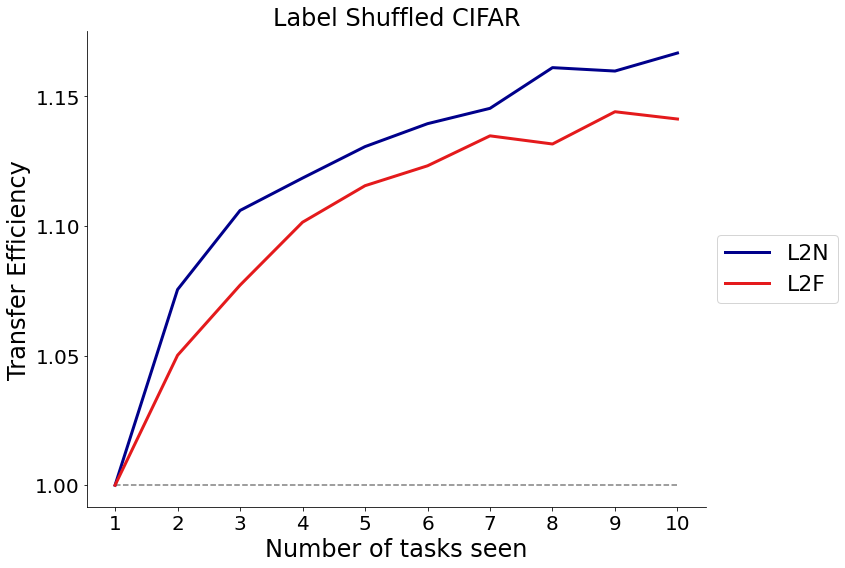

In [11]:
slots = 1
shifts = 6
alg_name = ['L2N','L2F']

reps = slots*shifts
btes = np.zeros((len(alg_name),10),dtype=float)

for alg_no,alg in enumerate(alg_name):
    bte_tmp = [[] for _ in range(reps)]

    count = 0   
    for slot in range(slots):
        for shift in range(shifts):
            if alg_no==0:
                filename = '../tutorials/result/dnn0_'+str(shift+1)+'_'+str(slot)+'.pickle'
            elif alg_no==1:
                filename = '../tutorials/result/uf10_'+str(shift+1)+'_'+str(slot)+'.pickle'
            else:
                filename = 'benchmarking_algorthms_result/'+alg+'_'+str(shift+1)+'_'+str(slot)+'.pickle'

            multitask_df = unpickle(filename)

            err = []

            for ii in range(10):
                err.extend(
                1 - np.array(
                    multitask_df[multitask_df['task']==ii+1]['task_1_accuracy']
                )
                )
            bte = get_bte(err)
        
            bte_tmp[count].extend(bte)
            count+=1
    
    btes[alg_no] = np.mean(bte_tmp, axis = 0)
    
clr = ["#00008B", "#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1,1, figsize=(10,8))

for alg_no,alg in enumerate(alg_name):
    if alg_no<2:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no], linewidth=3)
    else:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no])

ax.set_yticks([.9,.95, 1, 1.05,1.1,1.15,1.2])
ax.set_xticks(np.arange(1,11))
ax.tick_params(labelsize=20)
ax.set_xlabel('Number of tasks seen', fontsize=24)
ax.set_ylabel('Transfer Efficiency', fontsize=24)
ax.set_title("Label Shuffled CIFAR", fontsize = 24)
ax.hlines(1,1,10, colors='grey', linestyles='dashed',linewidth=1.5)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=22)
plt.savefig('../tutorials/result/figs/label_shufffle.pdf', dpi=500)